In [182]:
# import modules
import pandas
from sklearn import svm
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from pylab import *
import struct
import keras as ks
import logging
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from PIL import Image 
from scipy import misc
import os
# ...

## 读取数据
- 最后一列转数值

In [237]:
data_raw = pandas.read_csv("data/sla_level_container.csv")
data = np.array(data_raw)
data[:, -1] = np.array([float(value.split('%')[0]) for value in data[:, -1]])

## 重新定义Level
- level1: 0 ~ 50
- level2: 50 ~ 75
- level3: 75 ~ 95
- level4: 95 ~ 100

In [238]:
data[:, -2] = 0                   # level1:  0~50
data[:, -2][data[:, -1] > 50] = 1 # level2: 50~75
data[:, -2][data[:, -1] > 75] = 2 # level3: 75~95
data[:, -2][data[:, -1] > 95] = 3 # level4: 95~100
print(sum(data[:, -2] == 0))
print(sum(data[:, -2] == 1))
print(sum(data[:, -2] == 2))
print(sum(data[:, -2] == 3))
# level1: 95 ~ 100 867
# level2: 75 ~ 95  92
# level3: 50 ~ 75  72
# level4:  0 ~ 50  579

129
18
24
212


## 提取feature和label
- 第一行clock舍去
- 提取倒数第二列label => onehot 编码
- features归一化

In [239]:
features = data[:, 1:-2]
labels = np.array(data[:, -2],dtype=np.int)
tlabels = np.array(labels).reshape(len(labels), -1)
enc = OneHotEncoder()
enc.fit(tlabels)
oneHotLabels = enc.transform(tlabels).toarray()
for i in range(features.shape[1]):
    fmax = features[:, i].max()
    fmin = features[:, i].min()
    # avoid being divided by zero
    if fmax == fmin:
        features[:, i] = 0
        continue
    features[:, i] -= fmin
    features[:, i] /= (fmax-fmin)

## 分类模型
- 神经网络 135 => 128 => 64 => 32 => 16 => 4
- SVM等其他机器学习算法

In [253]:
target_names = ['level0', 'level1', 'level2', 'level3']
# save loss and acc
class LossHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        iindex = np.arange(0,len(self.losses[loss_type]),len(self.losses[loss_type])/100)
        iindex = np.array(iindex, dtype=np.int)
        iters = np.array(iters)
        plt.figure()
        # acc
        plt.plot(iters[iindex], np.array(self.accuracy[loss_type])[iindex], 'r', label='train acc')
        # loss
        plt.plot(iters[iindex], np.array(self.losses[loss_type])[iindex], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters[iindex], np.array(self.val_acc[loss_type])[iindex], 'b', label='val acc')
            # val_loss
            plt.plot(iters[iindex], np.array(self.val_loss[loss_type])[iindex], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        ylim(0,1.5)
        plt.legend(loc="upper right")
        plt.savefig('fig.png')
        
        plt.show()

        
def predict(model,data):
    tmp_res = model.predict(data)
    res = []
    for item in tmp_res:
        res.append(np.where(item == max(item))[0][0])
    return np.array(res)


def nn(f_t, f_tol, f_v, f_vol):
    tlabels = np.array(f_tol).reshape(len(f_tol), -1)
    enc = OneHotEncoder()
    enc.fit(tlabels)
    f_tl = enc.transform(np.array(f_tol).reshape(len(f_tol), -1)).toarray()
    f_vl = enc.transform(np.array(f_vol).reshape(len(f_vol), -1)).toarray()
    
    model = ks.models.Sequential()
    model.add(Dense(128, input_dim=f_t.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(f_tl.shape[1] + 1))
    model.add(Activation('softmax'))
    history = LossHistory()

    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    model.fit(x=f_t,y=f_tl,batch_size=128,nb_epoch=100,verbose=1,validation_data=(f_v,f_vl), callbacks=[history])
    
    print("train acc: {}".format(sum(predict(model,f_t) == f_tol)/len(f_tol)))
    y_true = f_tol
    y_pred = predict(model, f_t)
    print(classification_report(y_true, y_pred, target_names=target_names))

    print("val acc: {}".format(sum(predict(model,f_v) == f_vol)/len(f_vol)))
    y_true = f_vol
    y_pred = predict(model, f_v)
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    return (model, history)


def nsvm(model, f_t, f_tl, f_v, f_vl):
    max_layer = 4
    get_feature = K.function([model.layers[0].input],[model.layers[max_layer].output])
    mid_features_train = get_feature([f_t])[0]
    mid_features_test  = get_feature([f_v])[0]
    clf = svm.SVC()
    clf.fit(mid_features_train, f_tl)

    print("train acc: {}".format(clf.score(mid_features_train, f_tl)))
    y_true = f_tl
    y_pred = clf.predict(mid_features_train)
    print(classification_report(y_true, y_pred, target_names=target_names))

    print("val acc: {}".format(clf.score(mid_features_test, f_vl)))
    y_true = f_vl
    y_pred = clf.predict(mid_features_test)
    print(classification_report(y_true, y_pred, target_names=target_names))

    
def oml(f_t, f_tl, f_v, f_vl):
    classifiers = [
        KNeighborsClassifier(4),
        svm.SVC(kernel="linear", C=0.025),
        svm.SVC(),
        DecisionTreeClassifier(max_depth=3),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    ]
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest"]
    for name, clf in zip(names,classifiers):
        clf.fit(f_t, f_tl)
        print(name)
        print("train acc: {}".format(clf.score(f_t, f_tl)))
        y_true = f_tl
        y_pred = clf.predict(f_t)
        print(classification_report(y_true, y_pred, target_names=target_names))

        print("val acc: {}".format(clf.score(f_v, f_vl)))
        y_true = f_vl
        y_pred = clf.predict(f_v)
        print(classification_report(y_true, y_pred, target_names=target_names))
        print('\n')

In [252]:
(model,history) = nn(features, labels, features[101:400], labels[101:400,])

/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 383 samples, validate on 282 samples
Epoch 1/500
383/383 [==============================] - 1s 3ms/step - loss: 1.3726 - acc: 0.4073 - val_loss: 1.3111 - val_acc: 0.5284
Epoch 2/500
383/383 [==============================] - 0s 49us/step - loss: 1.2753 - acc: 0.7415 - val_loss: 1.1956 - val_acc: 0.8156
Epoch 3/500
383/383 [==============================] - 0s 49us/step - loss: 1.1264 - acc: 0.8460 - val_loss: 0.9539 - val_acc: 0.7624
Epoch 4/500
383/383 [==============================] - 0s 66us/step - loss: 0.9419 - acc: 0.7963 - val_loss: 0.8555 - val_acc: 0.7837
Epoch 5/500
383/383 [==============================] - 0s 65us/step - loss: 0.7584 - acc: 0.8590 - val_loss: 0.7161 - val_acc: 0.8191
Epoch 6/500
383/383 [==============================] - 0s 57us/step - loss: 0.6492 - acc: 0.8590 - val_loss: 0.8468 - val_acc: 0.7021
Epoch 7/500
383/383 [==============================] - 0s 49us/step - loss: 0.7359 - acc: 0.7885 - val_loss: 0.8082 - val_acc: 0.7589
Epoch 8/500
383/3

383/383 [==============================] - 0s 44us/step - loss: 0.1159 - acc: 0.9608 - val_loss: 0.1682 - val_acc: 0.9326
Epoch 122/500
383/383 [==============================] - 0s 51us/step - loss: 0.1757 - acc: 0.9243 - val_loss: 0.1968 - val_acc: 0.9362
Epoch 123/500
383/383 [==============================] - 0s 49us/step - loss: 0.1250 - acc: 0.9556 - val_loss: 0.1834 - val_acc: 0.9220
Epoch 124/500
383/383 [==============================] - 0s 44us/step - loss: 0.1384 - acc: 0.9504 - val_loss: 0.1577 - val_acc: 0.9574
Epoch 125/500
383/383 [==============================] - 0s 43us/step - loss: 0.1114 - acc: 0.9634 - val_loss: 0.1466 - val_acc: 0.9504
Epoch 126/500
383/383 [==============================] - 0s 47us/step - loss: 0.1215 - acc: 0.9478 - val_loss: 0.1734 - val_acc: 0.9149
Epoch 127/500
383/383 [==============================] - 0s 47us/step - loss: 0.1427 - acc: 0.9504 - val_loss: 0.2098 - val_acc: 0.9220
Epoch 128/500
383/383 [==============================] - 0s 58

383/383 [==============================] - 0s 39us/step - loss: 0.0947 - acc: 0.9530 - val_loss: 0.0891 - val_acc: 0.9539
Epoch 242/500
383/383 [==============================] - 0s 40us/step - loss: 0.0652 - acc: 0.9739 - val_loss: 0.0799 - val_acc: 0.9823
Epoch 243/500
383/383 [==============================] - 0s 42us/step - loss: 0.0549 - acc: 0.9843 - val_loss: 0.0728 - val_acc: 0.9752
Epoch 244/500
383/383 [==============================] - 0s 47us/step - loss: 0.0549 - acc: 0.9817 - val_loss: 0.0701 - val_acc: 0.9752
Epoch 245/500
383/383 [==============================] - 0s 44us/step - loss: 0.0551 - acc: 0.9765 - val_loss: 0.0681 - val_acc: 0.9752
Epoch 246/500
383/383 [==============================] - 0s 44us/step - loss: 0.0537 - acc: 0.9817 - val_loss: 0.0675 - val_acc: 0.9681
Epoch 247/500
383/383 [==============================] - 0s 40us/step - loss: 0.0485 - acc: 0.9817 - val_loss: 0.1130 - val_acc: 0.9504
Epoch 248/500
383/383 [==============================] - 0s 49

383/383 [==============================] - 0s 50us/step - loss: 0.0275 - acc: 0.9869 - val_loss: 0.0349 - val_acc: 0.9929
Epoch 362/500
383/383 [==============================] - 0s 45us/step - loss: 0.0369 - acc: 0.9817 - val_loss: 0.0741 - val_acc: 0.9787
Epoch 363/500
383/383 [==============================] - 0s 46us/step - loss: 0.0434 - acc: 0.9817 - val_loss: 0.0345 - val_acc: 0.9858
Epoch 364/500
383/383 [==============================] - 0s 65us/step - loss: 0.0273 - acc: 0.9896 - val_loss: 0.0413 - val_acc: 0.9965
Epoch 365/500
383/383 [==============================] - 0s 45us/step - loss: 0.0332 - acc: 0.9896 - val_loss: 0.0615 - val_acc: 0.9823
Epoch 366/500
383/383 [==============================] - 0s 68us/step - loss: 0.0398 - acc: 0.9843 - val_loss: 0.0428 - val_acc: 0.9752
Epoch 367/500
383/383 [==============================] - 0s 63us/step - loss: 0.0372 - acc: 0.9869 - val_loss: 0.0435 - val_acc: 0.9752
Epoch 368/500
383/383 [==============================] - 0s 60

383/383 [==============================] - 0s 46us/step - loss: 0.0142 - acc: 0.9974 - val_loss: 0.0223 - val_acc: 0.9929
Epoch 482/500
383/383 [==============================] - 0s 42us/step - loss: 0.0173 - acc: 0.9974 - val_loss: 0.0176 - val_acc: 0.9965
Epoch 483/500
383/383 [==============================] - 0s 43us/step - loss: 0.0152 - acc: 0.9948 - val_loss: 0.0191 - val_acc: 0.9965
Epoch 484/500
383/383 [==============================] - 0s 44us/step - loss: 0.0144 - acc: 0.9948 - val_loss: 0.0211 - val_acc: 0.9929
Epoch 485/500
383/383 [==============================] - 0s 49us/step - loss: 0.0258 - acc: 0.9896 - val_loss: 0.0400 - val_acc: 0.9823
Epoch 486/500
383/383 [==============================] - 0s 42us/step - loss: 0.0184 - acc: 0.9974 - val_loss: 0.0323 - val_acc: 0.9894
Epoch 487/500
383/383 [==============================] - 0s 46us/step - loss: 0.0257 - acc: 0.9869 - val_loss: 0.0193 - val_acc: 0.9965
Epoch 488/500
383/383 [==============================] - 0s 47

In [257]:
oml(features, labels, features[101:400,:], labels[101:400,])

Nearest Neighbors
train acc: 0.9608355091383812
             precision    recall  f1-score   support

     level0       0.98      0.99      0.99       129
     level1       0.91      0.56      0.69        18
     level2       0.81      0.88      0.84        24
     level3       0.97      0.99      0.98       212

avg / total       0.96      0.96      0.96       383

val acc: 0.9468085106382979
             precision    recall  f1-score   support

     level0       0.98      0.99      0.99       129
     level1       0.91      0.56      0.69        18
     level2       0.81      0.88      0.84        24
     level3       0.94      0.97      0.96       111

avg / total       0.95      0.95      0.94       282



Linear SVM
train acc: 0.8328981723237598
             precision    recall  f1-score   support

     level0       0.75      1.00      0.85       129
     level1       0.00      0.00      0.00        18
     level2       0.00      0.00      0.00        24
     level3       0.90    

/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


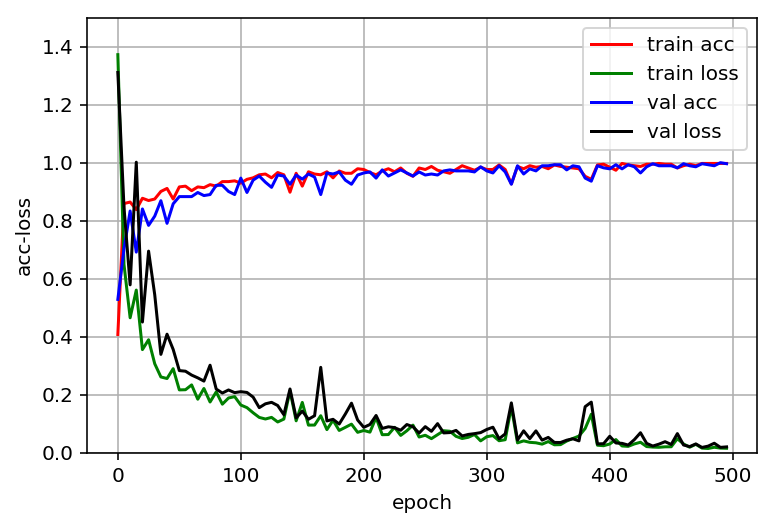

In [254]:
history.loss_plot('epoch')

In [256]:
nsvm(model, features, labels, features[101:400:], labels[101:400,])

train acc: 0.9869451697127938
             precision    recall  f1-score   support

     level0       0.98      1.00      0.99       129
     level1       1.00      0.72      0.84        18
     level2       0.96      1.00      0.98        24
     level3       0.99      1.00      1.00       212

avg / total       0.99      0.99      0.99       383

val acc: 0.9822695035460993
             precision    recall  f1-score   support

     level0       0.98      1.00      0.99       129
     level1       1.00      0.72      0.84        18
     level2       0.96      1.00      0.98        24
     level3       0.98      1.00      0.99       111

avg / total       0.98      0.98      0.98       282



In [258]:
labels.max()

3